# Text processing in global world

Let's write a function that counts distinct words in a given sentence:
1. Case-insensensetive comparison
2. Ignore punctuation
3. All numbers count as "__number__"
4. All "non-words" count as "__other__"

_All of the below code is for Python 3.6_

In [1]:
from collections import Counter
import re
import string

class WordCounterV1:
    # Translation table to remove punctuation
    punctuationTranslation = ''.maketrans('', '', string.punctuation)
    
    def CountWords( self, text ):
        counter = Counter()
        # Split text to words by spaces
        for word in text.split(' '):
            # Remove all punctuation
            word = word.translate(WordCounterV1.punctuationTranslation)
            if len(word) == 0:
                # Skip empty words
                continue
            # Words that consist only of letters count as words
            if re.match('^[a-zA-Z]+$', word):
                # Using casefold to get more stable case-insensetive variant
                counter[word.casefold()] += 1
            # Words that consist only of digits count as __number__
            elif re.match('^[0-9]+$', word):
                counter['__number__'] += 1
            # Everything else goes to __other__ bucket
            else:
                counter['__other__'] += 1
        return counter

Let's test it

In [2]:
wordCounter = WordCounterV1()
wordCounter.CountWords( 'Hello, World!' )

Counter({'hello': 1, 'world': 1})

Let's test is some more

In [3]:
wordCounter.CountWords( 'I think version 1 of our function will work fine for i18n, no need to create version 2.' )

Counter({'__number__': 2,
         '__other__': 1,
         'create': 1,
         'fine': 1,
         'for': 1,
         'function': 1,
         'i': 1,
         'need': 1,
         'no': 1,
         'of': 1,
         'our': 1,
         'think': 1,
         'to': 1,
         'version': 2,
         'will': 1,
         'work': 1})

And more

In [4]:
wordCounter.CountWords( 'But my fiancée thinks that this function will not work even in English' )

Counter({'__other__': 1,
         'but': 1,
         'english': 1,
         'even': 1,
         'function': 1,
         'in': 1,
         'my': 1,
         'not': 1,
         'that': 1,
         'thinks': 1,
         'this': 1,
         'will': 1,
         'work': 1})

Ok, we need to extend our letters set.<br>
But we need to be truly international, so we need all possible diacritics.<br>
And Cyrillic alphabet as well.<br>
And all kind of Indian scripts.<br>
And Thai language.<br>
And maybe few more things …?

## Unicode categories

[https://en.wikipedia.org/wiki/Unicode_character_property#General_Category](https://en.wikipedia.org/wiki/Unicode_character_property#General_Category)<br>
The Unicode Standard assigns character properties to each code point. These properties can be used to handle "characters" (code points) in processes, like in line-breaking, script direction right-to-left or applying controls.<br>
Each code point is assigned a value for General Category. This is one of the character properties that are also defined for unassigned code points, and code points that are defined "not a character".

Letters: Lu, Ll, Lt, Lm, Lo<br>
Marks: Mn, Mc, Me<br>
Numbers: Nd, Nl, No<br>
Punctuations: Pc, Pd, Ps, Pe, Pi, Pf, Po<br>
Symbols: Sm, Sc, Sk, So<br>
Separators: Zs, Zl, Zp<br>
<br>
Other, control: Cc<br>
Other, format: Cf<br>
Other, surrogate: Cs<br>
Other, private use: Co<br>
Other, not assigned: Cn

In [5]:
import unicodedata
unicodedata.category('a')

'Ll'

In [6]:
unicodedata.category('1')

'Nd'

In [7]:
unicodedata.category(' ')

'Zs'

Let's build unicode sets to work with

In [8]:
import unicodedata

def calculateUnicodeSets():
    punctuation = set()
    letters = set()
    numbers = set()
    spaces = set()
    control = set()
    # We go through whole range of possible Unicode characters
    for i in range(0,0x110000):
        char = chr(i)
        category = unicodedata.category( char )
        # Punctuation is everything in P* category
        if( category.startswith('P') ):
            punctuation.add( char )
        # For our goal both letters (L*) and mark signs (M*) will be considered as letters
        elif( category.startswith('L') or category.startswith('M') ):
            letters.add( char )
        # Nd and Nl goes to numbers (No is not exactly digits)
        elif( category == 'Nd' or category == 'Nl' ):
            numbers.add( char )
        # Z* goes to punctuation
        elif( category.startswith('Z') ):
            spaces.add( char )
        # We will need control (Cc) and format (Cf) characters a little bit later
        elif( category == 'Cc' or category == 'Cf' ):
            control.add( char )
    
    # TAB, CR and LF are in Cc category, but we will treat them as spaces
    spaces.add( '\t' )
    spaces.add( '\r' )
    spaces.add( '\n' )
    control.remove( '\t' )
    control.remove( '\r' )
    control.remove( '\n' )
    
    return (punctuation, letters, numbers, spaces, control)

In [9]:
(punctuation, letters, numbers, spaces, control) = calculateUnicodeSets()

Ok, we need universal letters set, but this function looks like overkill.<br>
Why we need punctuation, we already have string.punctuation?

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
''.join(sorted(punctuation))

'!"#%&\'()*,-./:;?@[\\]_{}¡§«¶·»¿;·՚՛՜՝՞՟։֊־׀׃׆׳״؉؊،؍؛؞؟٪٫٬٭۔܀܁܂܃܄܅܆܇܈܉܊܋܌܍߷߸߹࠰࠱࠲࠳࠴࠵࠶࠷࠸࠹࠺࠻࠼࠽࠾࡞।॥॰૰෴๏๚๛༄༅༆༇༈༉༊་༌།༎༏༐༑༒༔༺༻༼༽྅࿐࿑࿒࿓࿔࿙࿚၊။၌၍၎၏჻፠፡።፣፤፥፦፧፨᐀᙭᙮᚛᚜᛫᛬᛭᜵᜶។៕៖៘៙៚᠀᠁᠂᠃᠄᠅᠆᠇᠈᠉᠊᥄᥅᨞᨟᪠᪡᪢᪣᪤᪥᪦᪨᪩᪪᪫᪬᪭᭚᭛᭜᭝᭞᭟᭠᯼᯽᯾᯿᰻᰼᰽᰾᰿᱾᱿᳀᳁᳂᳃᳄᳅᳆᳇᳓‐‑‒–—―‖‗‘’‚‛“”„‟†‡•‣․‥…‧‰‱′″‴‵‶‷‸‹›※‼‽‾‿⁀⁁⁂⁃⁅⁆⁇⁈⁉⁊⁋⁌⁍⁎⁏⁐⁑⁓⁔⁕⁖⁗⁘⁙⁚⁛⁜⁝⁞⁽⁾₍₎⌈⌉⌊⌋〈〉❨❩❪❫❬❭❮❯❰❱❲❳❴❵⟅⟆⟦⟧⟨⟩⟪⟫⟬⟭⟮⟯⦃⦄⦅⦆⦇⦈⦉⦊⦋⦌⦍⦎⦏⦐⦑⦒⦓⦔⦕⦖⦗⦘⧘⧙⧚⧛⧼⧽⳹⳺⳻⳼⳾⳿⵰⸀⸁⸂⸃⸄⸅⸆⸇⸈⸉⸊⸋⸌⸍⸎⸏⸐⸑⸒⸓⸔⸕⸖⸗⸘⸙⸚⸛⸜⸝⸞⸟⸠⸡⸢⸣⸤⸥⸦⸧⸨⸩⸪⸫⸬⸭⸮⸰⸱⸲⸳⸴⸵⸶⸷⸸⸹⸺⸻⸼⸽⸾⸿⹀⹁⹂⹃⹄、。〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〽゠・꓾꓿꘍꘎꘏꙳꙾꛲꛳꛴꛵꛶꛷꡴꡵꡶꡷꣎꣏꣸꣹꣺꣼꤮꤯꥟꧁꧂꧃꧄꧅꧆꧇꧈꧉꧊꧋꧌꧍꧞꧟꩜꩝꩞꩟꫞꫟꫰꫱꯫﴾﴿︐︑︒︓︔︕︖︗︘︙︰︱︲︳︴︵︶︷︸︹︺︻︼︽︾︿﹀﹁﹂﹃﹄﹅﹆﹇﹈﹉﹊﹋﹌﹍﹎﹏﹐﹑﹒﹔﹕﹖﹗﹘﹙﹚﹛﹜﹝﹞﹟﹠﹡﹣﹨﹪﹫！＂＃％＆＇（）＊，－．／：；？＠［＼］＿｛｝｟｠｡｢｣､･𐄀𐄁𐄂𐎟𐏐𐕯𐡗𐤟𐤿𐩐𐩑𐩒𐩓𐩔𐩕𐩖𐩗𐩘𐩿𐫰𐫱𐫲𐫳𐫴𐫵𐫶𐬹𐬺𐬻𐬼𐬽𐬾𐬿𐮙𐮚𐮛𐮜𑁇𑁈𑁉𑁊𑁋𑁌𑁍𑂻𑂼𑂾𑂿𑃀𑃁𑅀𑅁𑅂𑅃𑅴𑅵𑇅𑇆𑇇𑇈𑇉𑇍𑇛𑇝𑇞𑇟𑈸𑈹𑈺𑈻𑈼𑈽𑊩𑑋𑑌𑑍𑑎𑑏𑑛𑑝𑓆𑗁𑗂𑗃𑗄𑗅𑗆𑗇𑗈𑗉𑗊𑗋𑗌𑗍𑗎𑗏𑗐𑗑𑗒𑗓𑗔𑗕𑗖𑗗𑙁𑙂𑙃𑙠𑙡𑙢𑙣𑙤𑙥𑙦𑙧𑙨𑙩𑙪𑙫𑙬𑜼𑜽𑜾𑱁𑱂𑱃𑱄𑱅𑱰𑱱𒑰𒑱𒑲𒑳𒑴𖩮𖩯𖫵𖬷𖬸𖬹𖬺𖬻𖭄𛲟𝪇𝪈𝪉𝪊𝪋𞥞𞥟'

But what about numbers, there are only 10 of them?<br>
You may treat different Number categories (Nd, Nl, No) differently, depending on your application.

In [13]:
''.join(sorted(numbers))

'0123456789٠١٢٣٤٥٦٧٨٩۰۱۲۳۴۵۶۷۸۹߀߁߂߃߄߅߆߇߈߉०१२३४५६७८९০১২৩৪৫৬৭৮৯੦੧੨੩੪੫੬੭੮੯૦૧૨૩૪૫૬૭૮૯୦୧୨୩୪୫୬୭୮୯௦௧௨௩௪௫௬௭௮௯౦౧౨౩౪౫౬౭౮౯೦೧೨೩೪೫೬೭೮೯൦൧൨൩൪൫൬൭൮൯෦෧෨෩෪෫෬෭෮෯๐๑๒๓๔๕๖๗๘๙໐໑໒໓໔໕໖໗໘໙༠༡༢༣༤༥༦༧༨༩၀၁၂၃၄၅၆၇၈၉႐႑႒႓႔႕႖႗႘႙ᛮᛯᛰ០១២៣៤៥៦៧៨៩᠐᠑᠒᠓᠔᠕᠖᠗᠘᠙᥆᥇᥈᥉᥊᥋᥌᥍᥎᥏᧐᧑᧒᧓᧔᧕᧖᧗᧘᧙᪀᪁᪂᪃᪄᪅᪆᪇᪈᪉᪐᪑᪒᪓᪔᪕᪖᪗᪘᪙᭐᭑᭒᭓᭔᭕᭖᭗᭘᭙᮰᮱᮲᮳᮴᮵᮶᮷᮸᮹᱀᱁᱂᱃᱄᱅᱆᱇᱈᱉᱐᱑᱒᱓᱔᱕᱖᱗᱘᱙ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫⅬⅭⅮⅯⅰⅱⅲⅳⅴⅵⅶⅷⅸⅹⅺⅻⅼⅽⅾⅿↀↁↂↅↆↇↈ〇〡〢〣〤〥〦〧〨〩〸〹〺꘠꘡꘢꘣꘤꘥꘦꘧꘨꘩ꛦꛧꛨꛩꛪꛫꛬꛭꛮꛯ꣐꣑꣒꣓꣔꣕꣖꣗꣘꣙꤀꤁꤂꤃꤄꤅꤆꤇꤈꤉꧐꧑꧒꧓꧔꧕꧖꧗꧘꧙꧰꧱꧲꧳꧴꧵꧶꧷꧸꧹꩐꩑꩒꩓꩔꩕꩖꩗꩘꩙꯰꯱꯲꯳꯴꯵꯶꯷꯸꯹０１２３４５６７８９𐅀𐅁𐅂𐅃𐅄𐅅𐅆𐅇𐅈𐅉𐅊𐅋𐅌𐅍𐅎𐅏𐅐𐅑𐅒𐅓𐅔𐅕𐅖𐅗𐅘𐅙𐅚𐅛𐅜𐅝𐅞𐅟𐅠𐅡𐅢𐅣𐅤𐅥𐅦𐅧𐅨𐅩𐅪𐅫𐅬𐅭𐅮𐅯𐅰𐅱𐅲𐅳𐅴𐍁𐍊𐏑𐏒𐏓𐏔𐏕𐒠𐒡𐒢𐒣𐒤𐒥𐒦𐒧𐒨𐒩𑁦𑁧𑁨𑁩𑁪𑁫𑁬𑁭𑁮𑁯𑃰𑃱𑃲𑃳𑃴𑃵𑃶𑃷𑃸𑃹𑄶𑄷𑄸𑄹𑄺𑄻𑄼𑄽𑄾𑄿𑇐𑇑𑇒𑇓𑇔𑇕𑇖𑇗𑇘𑇙𑋰𑋱𑋲𑋳𑋴𑋵𑋶𑋷𑋸𑋹𑑐𑑑𑑒𑑓𑑔𑑕𑑖𑑗𑑘𑑙𑓐𑓑𑓒𑓓𑓔𑓕𑓖𑓗𑓘𑓙𑙐𑙑𑙒𑙓𑙔𑙕𑙖𑙗𑙘𑙙𑛀𑛁𑛂𑛃𑛄𑛅𑛆𑛇𑛈𑛉𑜰𑜱𑜲𑜳𑜴𑜵𑜶𑜷𑜸𑜹𑣠𑣡𑣢𑣣𑣤𑣥𑣦𑣧𑣨𑣩𑱐𑱑𑱒𑱓𑱔𑱕𑱖𑱗𑱘𑱙𒐀𒐁𒐂𒐃𒐄𒐅𒐆𒐇𒐈𒐉𒐊𒐋𒐌𒐍𒐎𒐏𒐐𒐑𒐒𒐓𒐔𒐕𒐖𒐗𒐘𒐙𒐚𒐛𒐜𒐝𒐞𒐟𒐠𒐡𒐢𒐣𒐤𒐥𒐦𒐧𒐨𒐩𒐪𒐫𒐬𒐭𒐮𒐯𒐰𒐱𒐲𒐳𒐴𒐵𒐶𒐷𒐸𒐹𒐺𒐻𒐼𒐽𒐾𒐿𒑀𒑁𒑂𒑃𒑄𒑅𒑆𒑇𒑈𒑉𒑊𒑋𒑌𒑍𒑎𒑏𒑐𒑑𒑒𒑓𒑔𒑕𒑖𒑗𒑘𒑙𒑚𒑛𒑜𒑝𒑞𒑟𒑠𒑡𒑢𒑣𒑤𒑥𒑦𒑧𒑨𒑩𒑪𒑫𒑬𒑭𒑮𖩠𖩡𖩢𖩣𖩤𖩥𖩦𖩧𖩨𖩩𖭐𖭑𖭒𖭓𖭔𖭕𖭖𖭗𖭘𖭙𝟎𝟏𝟐𝟑𝟒𝟓𝟔𝟕𝟖𝟗𝟘𝟙𝟚𝟛𝟜𝟝𝟞𝟟𝟠𝟡𝟢𝟣𝟤𝟥𝟦𝟧𝟨𝟩𝟪𝟫𝟬𝟭𝟮𝟯𝟰𝟱𝟲𝟳𝟴𝟵𝟶𝟷𝟸𝟹𝟺𝟻𝟼𝟽𝟾𝟿𞥐𞥑𞥒𞥓𞥔𞥕𞥖𞥗𞥘𞥙'

What about spaces?

In [14]:
len(spaces)

22

In [15]:
''.join(sorted(spaces))

'\t\n\r \xa0\u1680\u2000\u2001\u2002\u2003\u2004\u2005\u2006\u2007\u2008\u2009\u200a\u2028\u2029\u202f\u205f\u3000'

Just for reference, how many letters we have?

In [16]:
len(letters)

118863

Let's get back to to our word counter.

In [17]:
from collections import Counter
import re

class WordCounterV2:
    def __init__(self):
        # Get all our unicode sets
        (self.punctuation, self.letters, self.numbers, self.spaces, self.control) = calculateUnicodeSets()
        # Translation table to remove punctuation
        self.punctuationTranslation = ''.maketrans('', '', ''.join(self.punctuation))
        # Translation table to remove control characters
        self.controlTranslation = ''.maketrans('', '', ''.join(self.control))
        # Regex to find all whitespaces
        self.whitespacesRegex = '|'.join(map(re.escape, self.spaces))
    
    def CountWords( self, text ):
        counter = Counter()
        # Remove control characters from string
        text = text.translate(self.controlTranslation)
        # Split text to words by whitespaces
        for word in re.split(self.whitespacesRegex,text,0):
            # Remove all punctuation
            word = word.translate(self.punctuationTranslation)
            if len(word) == 0:
                # Skip empty words
                continue
            # Creating set of letters from our word, that way it will be easier to compare with letters and numbers
            wordSet = set(word)
            # Words that consist only of letters count as words
            if wordSet.issubset( self.letters ):
                # Using casefold to get more stable case-insensetive variant
                counter[word.casefold()] += 1
            # Words that consist only of digits count as __number__
            elif wordSet.issubset( self.numbers ):
                counter['__number__'] += 1
            # Everything else goes to __other__ bucket
            else:
                counter['__other__'] += 1
        return counter

In [18]:
wordCounter = WordCounterV2()
wordCounter.CountWords( 'Hello, World!' )

Counter({'hello': 1, 'world': 1})

In [19]:
wordCounter.CountWords( 'Version 2 is working much better for i18n, i wonder do we really need version 3.' )

Counter({'__number__': 2,
         '__other__': 1,
         'better': 1,
         'do': 1,
         'for': 1,
         'i': 1,
         'is': 1,
         'much': 1,
         'need': 1,
         'really': 1,
         'version': 2,
         'we': 1,
         'wonder': 1,
         'working': 1})

In [20]:
wordCounter.CountWords( 'Текст, который не понимает большинство присутсвующих.' )

Counter({'большинство': 1,
         'который': 1,
         'не': 1,
         'понимает': 1,
         'присутсвующих': 1,
         'текст': 1})

Is our algorithm produces similiar result on similiar strings?

In [26]:
str1 = 'Tôi chỉ cần văn bản với dấu phụ'
str2 = 'Tôi chỉ cần văn bản với dấu phụ'

In [27]:
count1 = wordCounter.CountWords( str1 )
count2 = wordCounter.CountWords( str2 )

In [28]:
count1 + count2

Counter({'bản': 1,
         'bản': 1,
         'cần': 1,
         'chỉ': 1,
         'chỉ': 1,
         'cần': 1,
         'dấu': 1,
         'dấu': 1,
         'phụ': 1,
         'phụ': 1,
         'tôi': 1,
         'tôi': 1,
         'văn': 1,
         'với': 1,
         'văn': 1,
         'với': 1})

## Text Normalization

What happened in the previous example?<br>
There are several ways to write similiar text in Unicode.

In [29]:
','.join(list(str1))

'T,ô,i, ,c,h,ỉ, ,c,ầ,n, ,v,ă,n, ,b,ả,n, ,v,ớ,i, ,d,ấ,u, ,p,h,ụ'

In [30]:
','.join(list(str2))

'T,o,̂,i, ,c,h,i,̉, ,c,a,̂,̀,n, ,v,a,̆,n, ,b,a,̉,n, ,v,o,̛,́,i, ,d,a,̂,́,u, ,p,h,u,̣'

[http://unicode.org/reports/tr15/](http://unicode.org/reports/tr15/)<br>
__Canonical equivalence__ is a fundamental equivalency between characters or sequences of characters which represent the same abstract character, and which when correctly displayed should always have the same visual appearance and behavior.<br>
__Compatibility equivalence__ is a weaker type of equivalence between characters or sequences of characters which represent the same abstract character (or sequence of abstract characters), but which may have distinct visual appearances or behaviors.

Four types of normalization:
-  __NFD__: Canonical decomposition
-  __NFC__: Canonical Decomposition, followed by Canonical Composition
-  __NFKD__: Compatibility Decomposition
-  __NFKC__: Compatibility Decomposition, followed by Canonical Composition

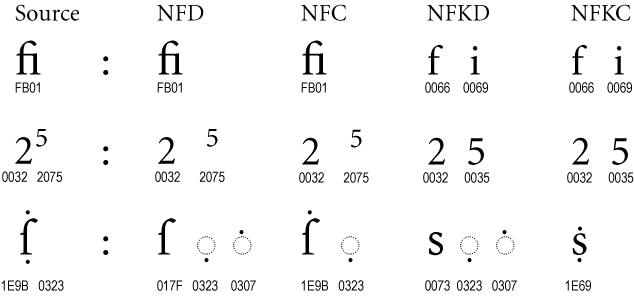

What type of normalization to use depends on your application and bussiness requirements.<br>
We will stick to NFKD in this example.

In [31]:
import unicodedata

str1Normalized = unicodedata.normalize("NFKD", str1)
str2Normalized = unicodedata.normalize("NFKD", str2)

In [32]:
','.join(list(str1Normalized))

'T,o,̂,i, ,c,h,i,̉, ,c,a,̂,̀,n, ,v,a,̆,n, ,b,a,̉,n, ,v,o,̛,́,i, ,d,a,̂,́,u, ,p,h,u,̣'

In [33]:
','.join(list(str2Normalized))

'T,o,̂,i, ,c,h,i,̉, ,c,a,̂,̀,n, ,v,a,̆,n, ,b,a,̉,n, ,v,o,̛,́,i, ,d,a,̂,́,u, ,p,h,u,̣'

In [34]:
str1 == str2

False

In [35]:
str1Normalized == str2Normalized

True

In [37]:
from collections import Counter
import re

class WordCounterV3:
    def __init__(self):
        # Get all our unicode sets
        (self.punctuation, self.letters, self.numbers, self.spaces, self.control) = calculateUnicodeSets()
        # Translation table to remove punctuation
        self.punctuationTranslation = ''.maketrans('', '', ''.join(self.punctuation))
        # Translation table to remove control characters
        self.controlTranslation = ''.maketrans('', '', ''.join(self.control))
        # Regex to find all whitespaces
        self.whitespacesRegex = '|'.join(map(re.escape, self.spaces))
    
    def CountWords( self, text ):
        counter = Counter()
        # Normalize text
        text = unicodedata.normalize("NFKD", text)
        # Remove control characters from string
        text = text.translate(self.controlTranslation)
        # Split text to words by whitespaces
        for word in re.split(self.whitespacesRegex,text,0):
            # Remove all punctuation
            word = word.translate(self.punctuationTranslation)
            if len(word) == 0:
                # Skip empty words
                continue
            # Creating set of letters from our word, that way it will be easier to compare with letters and numbers
            wordSet = set(word)
            # Words that consist only of letters count as words
            if wordSet.issubset( self.letters ):
                # Using casefold to get more stable case-insensetive variant
                counter[word.casefold()] += 1
            # Words that consist only of digits count as __number__
            elif wordSet.issubset( self.numbers ):
                counter['__number__'] += 1
            # Everything else goes to __other__ bucket
            else:
                counter['__other__'] += 1
        return counter

In [38]:
wordCounter = WordCounterV3()
wordCounter.CountWords( 'Hello, World!' )

Counter({'hello': 1, 'world': 1})

Let's try new version on previous example

In [39]:
count1Normalized = wordCounter.CountWords( str1 )
count2Normalized = wordCounter.CountWords( str2 )

In [40]:
count1Normalized + count2Normalized

Counter({'bản': 2,
         'cần': 2,
         'chỉ': 2,
         'dấu': 2,
         'phụ': 2,
         'tôi': 2,
         'văn': 2,
         'với': 2})

Can we combine our new results with previous ones?

In [41]:
count1Normalized + count2Normalized + count1 + count2

Counter({'bản': 3,
         'bản': 1,
         'cần': 3,
         'chỉ': 3,
         'chỉ': 1,
         'cần': 1,
         'dấu': 3,
         'dấu': 1,
         'phụ': 3,
         'phụ': 1,
         'tôi': 3,
         'tôi': 1,
         'văn': 3,
         'với': 3,
         'văn': 1,
         'với': 1})

__If you use predefined dictionary, make sure that it was created with the same type of normalization.__<br>
__The same goes to word embeddings, n-grams and any pre-trained text model.__

## Deeper into NLP territory

Is whitespace word-breaking enough for our need?

Sometimes even in English we may want more complex solution.

In [47]:
wordCounter.CountWords("Mr. O'Neill thinks that the boys' stories about Chile's capital aren't amusing.")

Counter({'about': 1,
         'amusing': 1,
         'arent': 1,
         'boys': 1,
         'capital': 1,
         'chiles': 1,
         'mr': 1,
         'oneill': 1,
         'stories': 1,
         'that': 1,
         'the': 1,
         'thinks': 1})

In [43]:
from nltk.tokenize import word_tokenize

In [44]:
word_tokenize("Mr. O'Neill thinks that the boys' stories about Chile's capital aren't amusing.",'English')

['Mr.',
 "O'Neill",
 'thinks',
 'that',
 'the',
 'boys',
 "'",
 'stories',
 'about',
 'Chile',
 "'s",
 'capital',
 'are',
 "n't",
 'amusing',
 '.']

In [ ]:
from nltk.tokenize.toktok import ToktokTokenizer

In [ ]:
tokenizer = ToktokTokenizer()

In [ ]:
tokenizer.tokenize('Rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz')

In [ ]:
import spacy
nlp = spacy.load('de')

from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

from spacy.lemmatizer import Lemmatizer
lemmatizer = Lemmatizer()

doc = tokenizer('Rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz')

In [ ]:
print([(w.text, w.pos_) for w in doc])